In [1]:
import random
from enum import Enum, unique
from typing import List

import matplotlib
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import yaml
from PIL import Image
from tensorboardX import SummaryWriter
from torch.multiprocessing import freeze_support
from torch.utils.data import DataLoader, Dataset
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed


sns.set_style()
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams["font.family"] = "Rubik"
sns.set_context("paper")


from pit.dynamics.kinematic_bicycle import Bicycle
from pit.dynamics.unicycle import Unicycle
from pit.integration import Euler, RK4
from vmp.data_utils import get_map_points, TraceRelativeDataset, centerline, map_x, map_y
from vmp.utils import Method, DynamicModel, Curvature, frenet_to_point, point_to_frenet, get_interpolated_point
from vmp.viz_utils import create_debug_plot, create_single_plot
from vmp.networks import LSTMPredictorPCMP, LSTMPredictor, get_model
from vmp.losses import *
from vmp.data_utils import TraceRelativeDataset, TRAIN_LIST, VAL_LIST, TEST_LIST, RACE_TEST_LIST, map_x, map_y, CAR_LENGTH, CAR_WIDTH
from toy_problem_library import test_model

In [55]:
def create_single_plot(input, target, prediction, ax=None, heading_boxes=True, buffer=0.5, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(**kwargs)
    else:
        fig = None
    assert(isinstance(input, np.ndarray))
    assert(isinstance(target, np.ndarray))
    assert(isinstance(prediction, np.ndarray))
    
    (linput,) = ax.plot(
        input[:, 0],
        input[:, 1],
        marker=".",
        label="Input",
    )
    (ltarget,) = ax.plot(
        target[:, 0],
        target[:, 1],
        marker=".",
        label="Truth",
    )
    (lpred,) = ax.plot(
        prediction[:, 0],
        prediction[:, 1],
        marker=".",
        label="Prediction",
    )

    if heading_boxes:
        center = (prediction[-1, 0], prediction[-1, 1])
        corner = [center[0] - (CAR_LENGTH / 2), center[1] - (CAR_WIDTH / 2)]
        ax.add_patch(
            plt.Rectangle(
                corner,
                CAR_LENGTH,
                CAR_WIDTH,
                edgecolor="green",
                fill=False,
                angle=rad_to_deg(prediction[-1, 2]),
                rotation_point=center,
            )
        )

        center = (target[-1, 0], target[-1, 1])
        corner = [center[0] - (CAR_LENGTH / 2), center[1] - (CAR_WIDTH / 2)]
        ax.add_patch(
            plt.Rectangle(
                corner,
                CAR_LENGTH,
                CAR_WIDTH,
                edgecolor="orange",
                fill=False,
                angle=rad_to_deg(target[-1, 2]),
                rotation_point=center,
            )
        )
        center = (prediction[-30, 0], prediction[-30, 1])
        corner = [center[0] - (CAR_LENGTH / 2), center[1] - (CAR_WIDTH / 2)]
        ax.add_patch(
            plt.Rectangle(
                corner,
                CAR_LENGTH,
                CAR_WIDTH,
                edgecolor="green",
                fill=False,
                angle=rad_to_deg(prediction[-30, 2]),
                rotation_point=center,
            )
        )
        center = (
            target[-30, 0],
            target[-30, 1],
        )
        corner = [center[0] - (CAR_LENGTH / 2), center[1] - (CAR_WIDTH / 2)]
        ax.add_patch(
            plt.Rectangle(
                corner,
                CAR_LENGTH,
                CAR_WIDTH,
                edgecolor="orange",
                fill=False,
                angle=rad_to_deg(target[-30, 2]),
                rotation_point=center,
            )
        )

        center = (
            input[-1, 0],
            input[-1, 1],
        )
        corner = [center[0] - (CAR_LENGTH / 2), center[1] - (CAR_WIDTH / 2)]
        ax.add_patch(
            plt.Rectangle(
                corner,
                CAR_LENGTH,
                CAR_WIDTH,
                edgecolor="blue",
                fill=False,
                angle=rad_to_deg(input[-1, 2]),
                rotation_point=center,
            )
        )

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    max_offset_x = max(np.mean(xlim) - xlim[0], xlim[1] - np.mean(xlim))
    max_offset_y = max(np.mean(ylim) - ylim[0], ylim[1] - np.mean(ylim))
    max_offset = max(max_offset_x, max_offset_y) + buffer
    ax.scatter(map_x, map_y, marker=".", color="black")
    ax.set(
        xlim=(np.mean(xlim) - max_offset, np.mean(xlim) + max_offset),
        ylim=(np.mean(ylim) - max_offset, np.mean(ylim) + max_offset),
        aspect=1.0,
        #adjustable="box",
        yticklabels=[],
        xticklabels=[],
    )
    ax.tick_params(          
        axis='both',
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left=False,
        right=False,
        labelbottom=False
    )
    if fig is None:
        return ax
    else:
        return fig, ax

In [2]:
def rad_to_deg(radians):
    return radians*57.29578

In [3]:
DEVICE = 'cuda:1'

In [4]:
train_frame = pd.read_pickle("../../data/train_data.pkl")
val_frame = pd.read_pickle("../../data/val_data.pkl")
test_frame = pd.read_pickle("../../data/test_data.pkl")
full_frame = pd.read_pickle("../../data/final_data.pkl")
no_race_val_frame = val_frame[
    val_frame["selected_lane"].apply(
        lambda x: True if x in ["left", "center", "right"] else False
    )
]
race_val_frame = val_frame[
    val_frame["selected_lane"].apply(
        lambda x: True if x in ["race"] else False
    )
]
no_race_test_frame = test_frame[
    test_frame["selected_lane"].apply(
        lambda x: True if x in ["left", "center", "right"] else False
    )
]
race_test_frame = test_frame[
    test_frame["selected_lane"].apply(lambda x: True if x in ["race"] else False)
]

In [5]:
train_dataset = TraceRelativeDataset(train_frame, curve=True, random_noise=True)
test_dataset = TraceRelativeDataset(test_frame, curve=True, random_noise=True)
val_dataset = TraceRelativeDataset(val_frame, curve=True, random_noise=True)
no_race_val_dataset = TraceRelativeDataset(no_race_val_frame, curve=True, random_noise=True)
race_val_dataset = TraceRelativeDataset(race_val_frame, curve=True, random_noise=True)
no_race_test_dataset = TraceRelativeDataset(no_race_test_frame, curve=True, random_noise=True)
race_test_dataset = TraceRelativeDataset(race_test_frame, curve=True, random_noise=True)
#debug_dataset = TraceRelativeDataset(val_frame[:512], curve=True)
#debug_dataloader = DataLoader(debug_dataset, batch_size=512, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1024, shuffle=True)
train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1024, shuffle=True)
no_race_val_dataloader = DataLoader(no_race_val_dataset, batch_size=1024, shuffle=True)
race_val_dataloader = DataLoader(race_val_dataset, batch_size=1024, shuffle=True)
no_race_test_dataloader = DataLoader(no_race_test_dataset, batch_size=1024, shuffle=True)
race_test_dataloader = DataLoader(race_test_dataset, batch_size=1024, shuffle=True)

In [45]:
path_root = "runs/final-toy/robustness-longer/LSTM-CURVATURE-16-P6044-NOCURR-CUSTOMLOSS-0/"
#path_root = "runs/final-toy/performance-comparison/LSTM-CURVATURE-16-P6044-NOCURR-DISPLOSS/"

meta = torch.load(path_root+"last_model_meta.pt")
config = meta['config']
net, optimizer, directory, config_dict = get_model(config)
config_dict["DEVICE"] = DEVICE
net.load_state_dict(torch.load(path_root+"last_model.pt"))
net.to(DEVICE)
net.eval()
for input, last_pose, target in train_dataloader:
    break
display(input.shape)
display(last_pose.shape)
display(target.shape)
input = input.to(DEVICE)
last_pose = last_pose.to(DEVICE)
#other_outp, other_outp_control = net.predict(input, last_pose)
other_outp = net.predict(input, last_pose)
other_outp.shape

torch.Size([1024, 10, 10])

torch.Size([1024, 4])

torch.Size([1024, 60, 3])

torch.Size([1024, 60, 3])

In [81]:
path_root = "runs/final-toy/robustness-longer/PIMP-60-16-P5505-0.001-BICYCLE-CURR-2-WB0.3302-NORESID-CUSTOMLOSS-2/"
#path_root = "runs/final-toy/performance-comparison/LSTM-CURVATURE-16-P6044-NOCURR-DISPLOSS/"

meta = torch.load(path_root+"last_model_meta.pt")
config = meta['config']
pcmpnet, optimizer, directory, config_dict = get_model(config)
config_dict["DEVICE"] = DEVICE
pcmpnet.load_state_dict(torch.load(path_root+"last_model.pt"))
pcmpnet.to(DEVICE)
pcmpnet.eval()
for input, last_pose, target in train_dataloader:
    break
display(input.shape)
display(last_pose.shape)
display(target.shape)
input = input.to(DEVICE)
last_pose = last_pose.to(DEVICE)
#other_outp, other_outp_control = net.predict(input, last_pose)
other_outp = net.predict(input, last_pose)
other_outp.shape

torch.Size([1024, 10, 10])

torch.Size([1024, 4])

torch.Size([1024, 60, 3])

torch.Size([1024, 60, 3])

In [82]:
meta['epoch']

349

In [47]:
meta['config']

{'hidden_dim': 16,
 'epochs': 350,
 'control_outputs': 10,
 'curriculum': False,
 'eps_per_input': 2,
 'prefix': 'runs/final-toy/robustness-longer/',
 'batch_size': 512,
 'DEVICE': 'cuda:1',
 'wheelbase': 0.3302,
 'residual': False,
 'model': <DynamicModel.BICYCLE: 0>,
 'robustness': True,
 'wd': 1e-05,
 'lr': 0.001,
 'momentum': 0.8,
 'horizon': 60,
 'timestep': 0.01,
 'loss_func': 'custom',
 'save_all': False,
 'method': <Method.LSTM: 1>,
 'curvature': <Curvature.CURVATURE: 1>,
 'job_id': 0,
 'output_queue': None,
 'pytorch_total_params': 6044}

In [84]:
IDX = 42039#VAL_LIST[2]#43226
with torch.no_grad():
    input = torch.tensor(full_frame.loc[IDX]['input_vel'], device=DEVICE).unsqueeze(0)
    target = torch.tensor(full_frame.loc[IDX]['target'], device=DEVICE).unsqueeze(0)
    last_pose = torch.tensor(full_frame.loc[IDX]['last_pose'], device=DEVICE).unsqueeze(0)
    output = net.predict(input, last_pose)
    pcmp_output, _ = pcmpnet.predict(input, last_pose)
input, target, prediction = input.squeeze(0).cpu().numpy(), target.squeeze(0).cpu().numpy(), output.squeeze(0).cpu().numpy()
pcmp_output = pcmp_output.squeeze(0).cpu().numpy()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


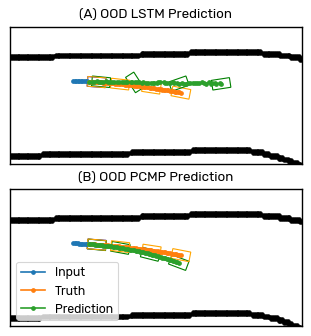

In [98]:
fig, axs = plt.subplots(2,1, figsize=(3.25,3.25), constrained_layout=True)
(linput,) = axs[0].plot(
    input[:, 0],
    input[:, 1],
    marker=".",
    label="Input",
)
(ltarget,) = axs[0].plot(
    target[:, 0],
    target[:, 1],
    marker=".",
    label="Truth",
)
(lpred,) = axs[0].plot(
    prediction[:, 0],
    prediction[:, 1],
    marker=".",
    label="Prediction",
)

corner = [center[0] - (CAR_LENGTH / 2), center[1] - (CAR_WIDTH / 2)]
axs[0].add_patch(
    plt.Rectangle(
        corner,
        CAR_LENGTH,
        CAR_WIDTH,
        edgecolor="blue",
        fill=False,
        angle=rad_to_deg(input[-1, 2]),
        rotation_point=center,
    )
)

for index in [-1, -20, -40, -55,]:
    center = (prediction[index, 0], prediction[index, 1])
    corner = [center[0] - (CAR_LENGTH / 2), center[1] - (CAR_WIDTH / 2)]
    axs[0].add_patch(
        plt.Rectangle(
            corner,
            CAR_LENGTH,
            CAR_WIDTH,
            edgecolor="green",
            fill=False,
            angle=rad_to_deg(prediction[index, 2]),
            rotation_point=center,
        )
    )
    center = (
        target[index, 0],
        target[index, 1],
    )
    corner = [center[0] - (CAR_LENGTH / 2), center[1] - (CAR_WIDTH / 2)]
    axs[0].add_patch(
        plt.Rectangle(
            corner,
            CAR_LENGTH,
            CAR_WIDTH,
            edgecolor="orange",
            fill=False,
            angle=rad_to_deg(target[index, 2]),
            rotation_point=center,
        )
    )


axs[0].set_aspect("equal")
xlim = axs[0].get_xlim()
ylim = axs[0].get_ylim()
axs[0].scatter(map_x, map_y, color="black", marker=".")
axs[0].set(
    xlim=(xlim[0] - 1.75, xlim[1] + 2),
    ylim=(ylim[0] - 2, ylim[1] + 1.4),
)
axs[0].tick_params(          
        axis='both',
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left=False,
        right=False,
        labelbottom=False
    )
axs[0].set_yticklabels([])
axs[0].set_xticklabels([])
axs[0].set_title("(A) OOD LSTM Prediction")

(linput,) = axs[1].plot(
    input[:, 0],
    input[:, 1],
    marker=".",
    label="Input",
)
(ltarget,) = axs[1].plot(
    target[:, 0],
    target[:, 1],
    marker=".",
    label="Truth",
)
(lpred,) = axs[1].plot(
    pcmp_output[:, 0],
    pcmp_output[:, 1],
    marker=".",
    label="Prediction",
)

corner = [center[0] - (CAR_LENGTH / 2), center[1] - (CAR_WIDTH / 2)]
axs[1].add_patch(
    plt.Rectangle(
        corner,
        CAR_LENGTH,
        CAR_WIDTH,
        edgecolor="blue",
        fill=False,
        angle=rad_to_deg(input[-1, 2]),
        rotation_point=center,
    )
)

for index in [-1, -20, -40, -55,]:
    center = (pcmp_output[index, 0], pcmp_output[index, 1])
    corner = [center[0] - (CAR_LENGTH / 2), center[1] - (CAR_WIDTH / 2)]
    axs[1].add_patch(
        plt.Rectangle(
            corner,
            CAR_LENGTH,
            CAR_WIDTH,
            edgecolor="green",
            fill=False,
            angle=rad_to_deg(pcmp_output[index, 2]),
            rotation_point=center,
        )
    )
    center = (
        target[index, 0],
        target[index, 1],
    )
    corner = [center[0] - (CAR_LENGTH / 2), center[1] - (CAR_WIDTH / 2)]
    axs[1].add_patch(
        plt.Rectangle(
            corner,
            CAR_LENGTH,
            CAR_WIDTH,
            edgecolor="orange",
            fill=False,
            angle=rad_to_deg(target[index, 2]),
            rotation_point=center,
        )
    )


axs[1].set_aspect("equal")
axs[1].scatter(map_x, map_y, color="black", marker=".")
axs[1].set(
    xlim=(xlim[0] - 1.75, xlim[1] + 2),
    ylim=(ylim[0] - 2, ylim[1] + 1.4),
)
axs[1].tick_params(          
        axis='both',
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left=False,
        right=False,
        labelbottom=False
    )
axs[1].set_yticklabels([])
axs[1].set_xticklabels([])
axs[1].set_title("(B) OOD PCMP Prediction")
axs[1].legend(loc='lower left')
plt.savefig("plotting/robustness-error.eps")

0.44206929206848145

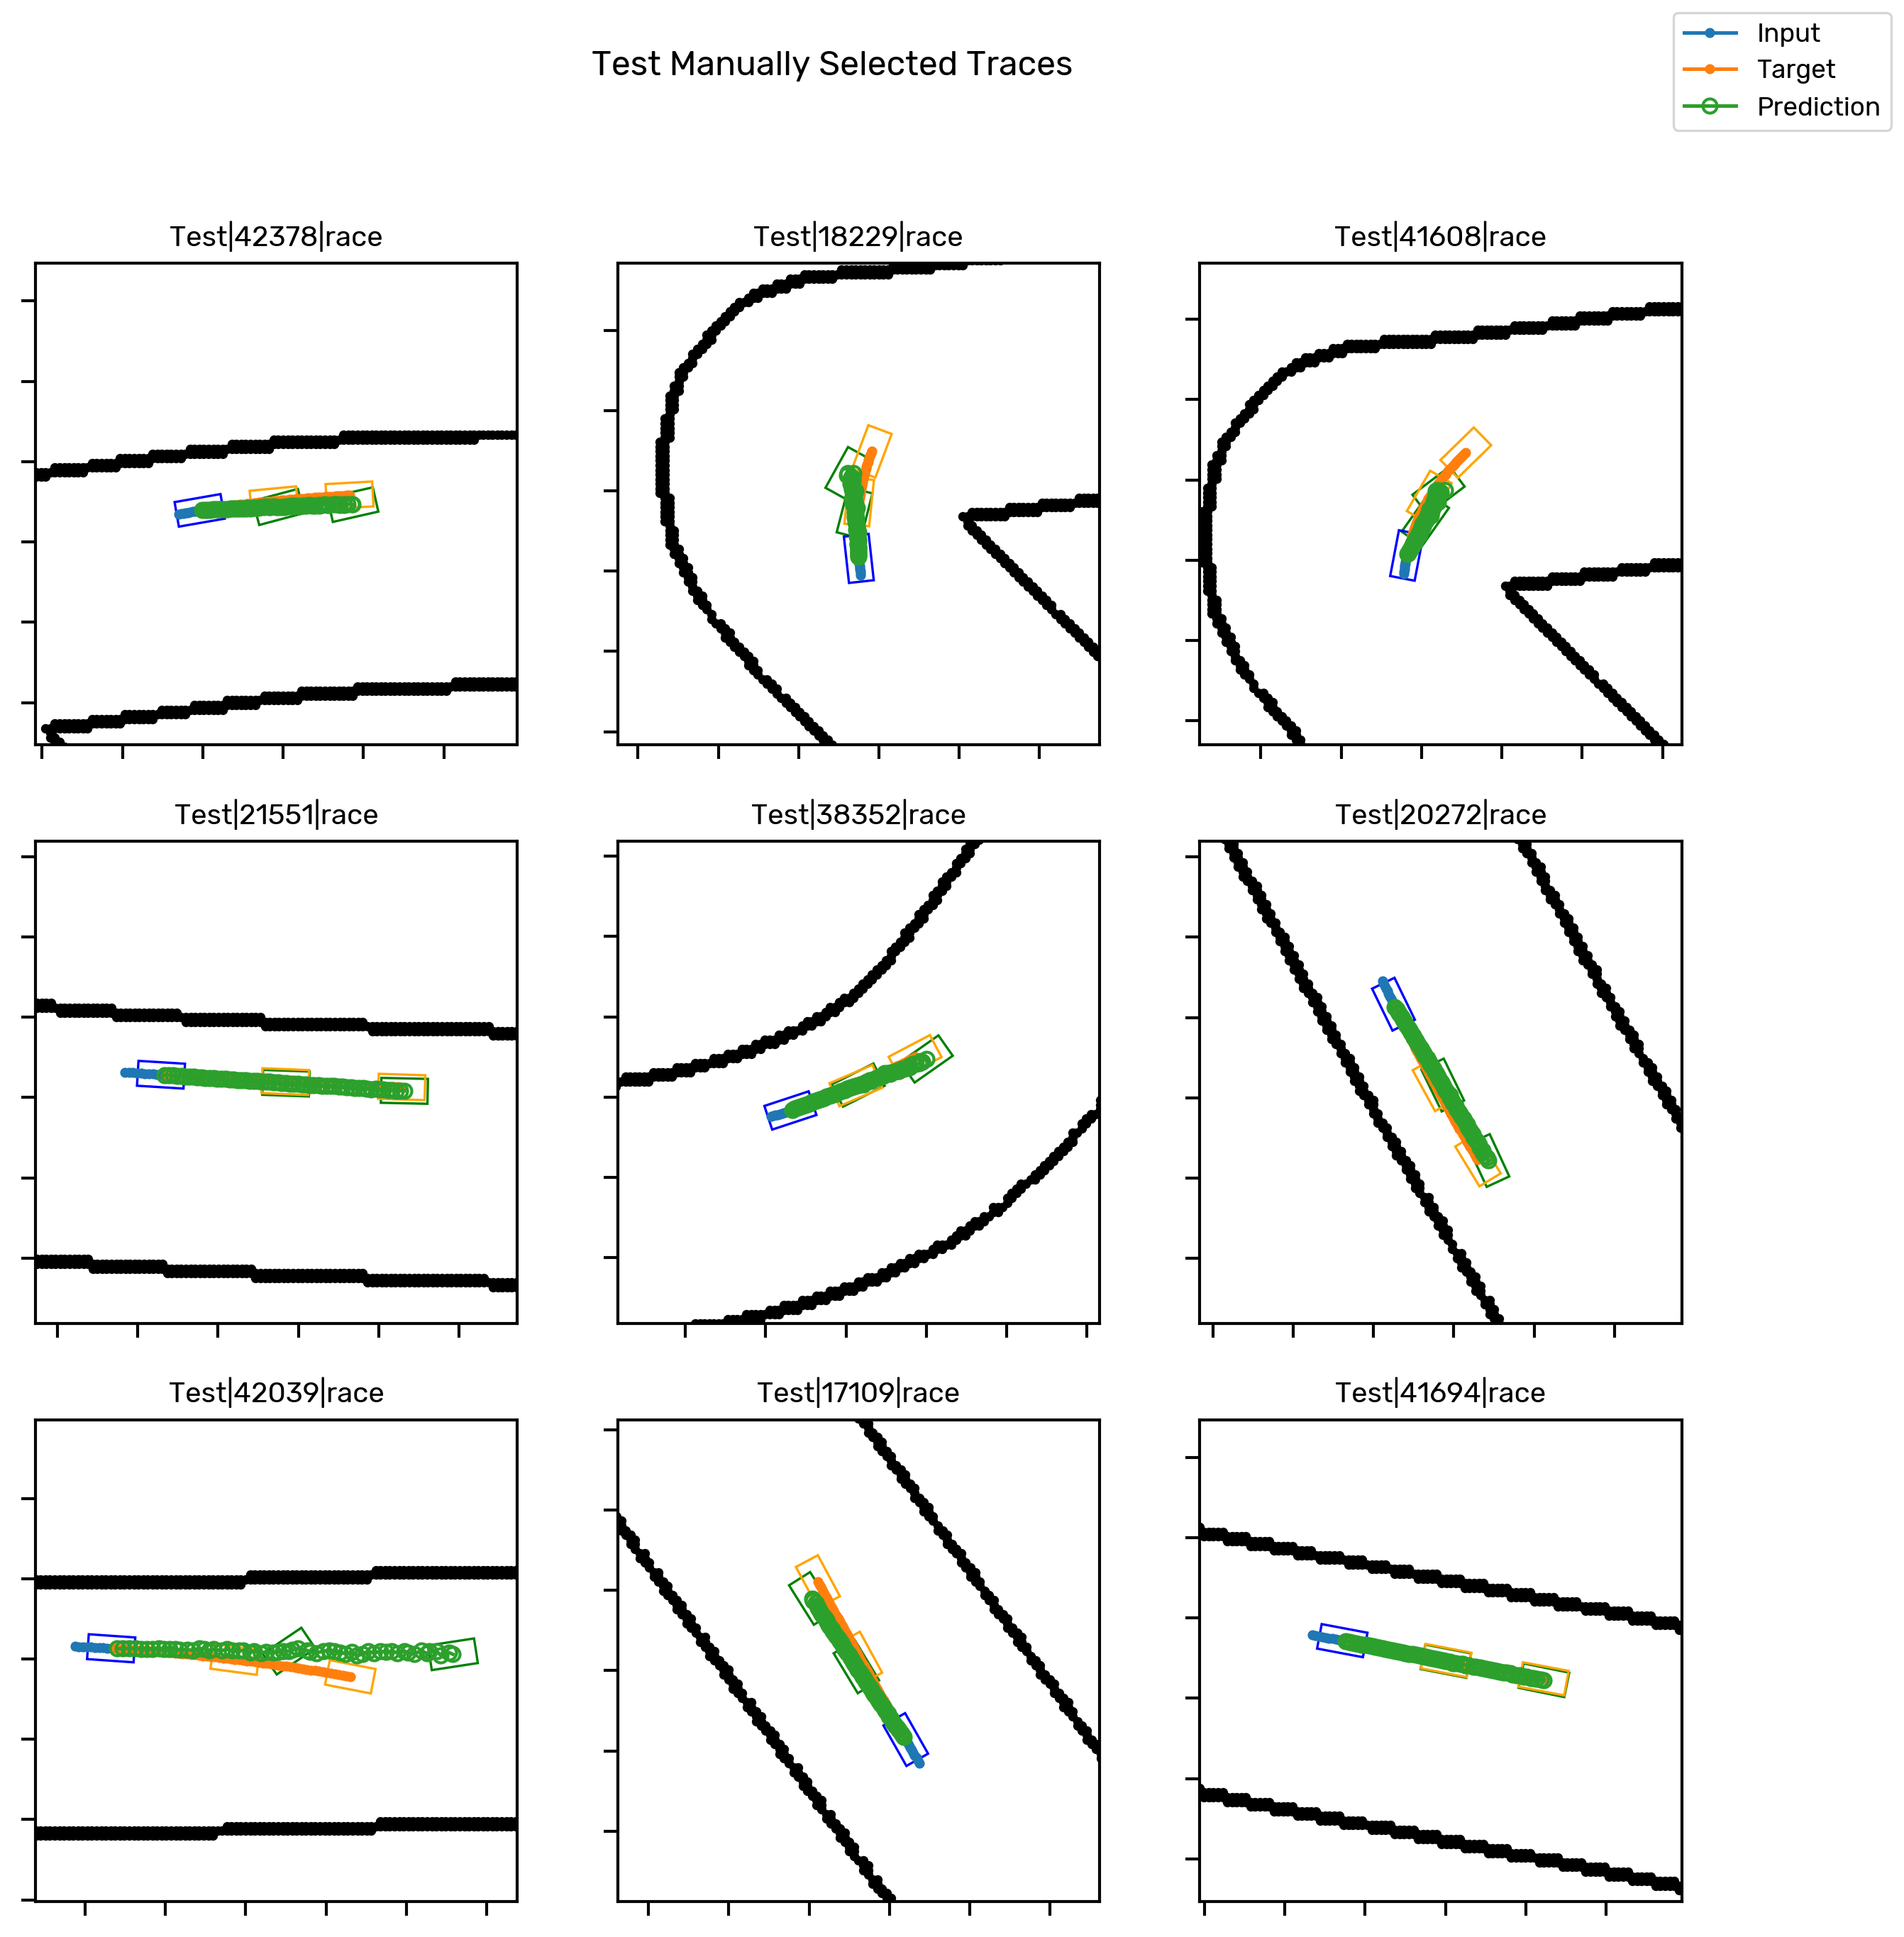

In [48]:
import time
start = time.time()
create_debug_plot(
    net, 
    train_dataset=train_dataloader.dataset, 
    test_dataset=test_dataloader.dataset, 
    val_dataset=val_dataloader.dataset, 
    curvature=config['curvature'], 
    DEVICE=DEVICE, 
    full_frame=full_frame, 
    dataset_name="race_test"
)
end = time.time()
end-start

In [10]:
def get_metric_distribution(path, samples=30, dataloader=test_dataloader, dataset_name='test'):
    from vmp.utils import set_seed
    meta = torch.load(path+"last_model_meta.pt")
    config = meta['config']
    net, optimizer, directory, config_dict = get_model(config)
    config_dict["DEVICE"] = DEVICE
    net.load_state_dict(torch.load(path+"last_model.pt"))
    net.to(DEVICE)
    net.eval()

    ades = list()
    fdes = list()
    head_errs = list()
    iou_errs = list()

    for i in tqdm(range(samples)):
        ade, fde, cum_head_err, iou_err, cum_test_loss, test_fig, end_index, element_results = test_model(
            config_dict=config_dict,
            net=net,
            dataloader=dataloader,
            loss_func=custom_loss_func,
            epoch=350,
            curriculum_steps=1,
            dataset_name=dataset_name,
            histogram_results=True,
            iou=True,
            image=False,
            seed=i,
        )
        ades.append(ade)
        fdes.append(fde)
        head_errs.append(cum_head_err)
        iou_errs.append(iou_err)
    return {
        'path': path,
        'ades': ades,
        'fdes': fdes,
        'heading_errors': head_errs,
        'iou_errors': iou_errs,
        'training_loss': meta['train_losses'][-1],
    }


In [11]:
get_metric_distribution("runs/final-toy/performance-comparison/CTRV-60-P0-0.001-0/", 3, dataloader=race_test_dataloader, dataset_name='race_test')

  0%|          | 0/3 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/root/miniconda3/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/root/miniconda3/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/root/miniconda3/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/root/miniconda3/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/root/miniconda3/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in

{'path': 'runs/final-toy/performance-comparison/CTRV-60-P0-0.001-0/',
 'ades': [0.263644970946051, 0.2663420568058147, 0.26894755956545396],
 'fdes': [0.7605324816347948, 0.7660478126943407, 0.7748056592039801],
 'heading_errors': [0.008749765424586053,
  0.008803454916275556,
  0.008814322058834246],
 'iou_errors': [0.4310953168726679, 0.43108116643345773, 0.4330868849113806],
 'training_loss': 0.044995291921485395}

In [12]:
get_metric_distribution("runs/final-toy/robustness-longer/LSTM-CURVATURE-16-P6044-NOCURR-CUSTOMLOSS-0/", 3, dataloader=race_test_dataloader, dataset_name='race_test')

  0%|          | 0/3 [00:00<?, ?it/s]

{'path': 'runs/final-toy/robustness-longer/LSTM-CURVATURE-16-P6044-NOCURR-CUSTOMLOSS-0/',
 'ades': [0.15294241074898943, 0.15290077930659204, 0.15258552209654852],
 'fdes': [0.3027694778062811, 0.3026825103000622, 0.30224463619402986],
 'heading_errors': [0.0011563227544376506,
  0.0011571792820792887,
  0.00115437709276949],
 'iou_errors': [0.5308633832789179, 0.5314675402285448, 0.5321530166550063],
 'training_loss': 0.0014055726665907953}

In [13]:
from joblib import Parallel, delayed
import datetime
jobs = [
    "runs/final-toy/performance-comparison/CTRV-60-P0-0.001-0/",
    "runs/final-toy/robustness-longer/LSTM-CURVATURE-16-P6044-NOCURR-CUSTOMLOSS-0/",
    "runs/final-toy/robustness-longer/PIMP-60-16-P5505-0.001-BICYCLE-NOCURR-WB0.3302-NORESID-CUSTOMLOSS-1/",
    "runs/final-toy/robustness-longer/PIMP-60-16-P5505-0.001-BICYCLE-CURR-2-WB0.3302-NORESID-CUSTOMLOSS-2/",
]
#results = Parallel(n_jobs=5, verbose=10)(delayed(get_metric_distribution)(i, 3) for i in jobs)
results =[get_metric_distribution(i, dataloader=race_test_dataloader, dataset_name='race_test') for i in jobs]

#pimp_curr_2 = get_metric_distribution("runs/final-toy/performance-comparison/PIMP-60-16-P5505-0.001-BICYCLE-CURR-2-WB0.3302-NORESID-CUSTOMLOSS/")
#pimp_no_curr = get_metric_distribution("runs/final-toy/performance-comparison/PIMP-60-16-P5505-0.001-BICYCLE-NOCURR-WB0.3302-NORESID-CUSTOMLOSS/")
#lstm = get_metric_distribution("runs/final-toy/performance-comparison/LSTM-CURVATURE-16-P6044-NOCURR-DISPLOSS/")
print(results[0]['path'])

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

runs/final-toy/performance-comparison/CTRV-60-P0-0.001-0/


In [31]:
import pathlib
for res in results:
    res['name'] = pathlib.PurePath(res['path']).name

In [32]:
str(results[0]['name'])

'CTRV-60-P0-0.001-0'

In [34]:
[res['path'] for res in results]

['runs/final-toy/performance-comparison/CTRV-60-P0-0.001-0/',
 'runs/final-toy/robustness-longer/LSTM-CURVATURE-16-P6044-NOCURR-CUSTOMLOSS-0/',
 'runs/final-toy/robustness-longer/PIMP-60-16-P5505-0.001-BICYCLE-NOCURR-WB0.3302-NORESID-CUSTOMLOSS-1/',
 'runs/final-toy/robustness-longer/PIMP-60-16-P5505-0.001-BICYCLE-CURR-2-WB0.3302-NORESID-CUSTOMLOSS-2/']

In [39]:
metric='ades'
print(metric)
for res in results:
    print(f"{res['name']:<70}  MEAN: {np.mean(res[metric]):4f}  STDDEV: {np.std(res[metric]):4f}")

ades
CTRV-60-P0-0.001-0                                                      MEAN: 0.267870  STDDEV: 0.005842
LSTM-CURVATURE-16-P6044-NOCURR-CUSTOMLOSS-0                             MEAN: 0.152849  STDDEV: 0.000278
PIMP-60-16-P5505-0.001-BICYCLE-NOCURR-WB0.3302-NORESID-CUSTOMLOSS-1     MEAN: 0.055924  STDDEV: 0.000347
PIMP-60-16-P5505-0.001-BICYCLE-CURR-2-WB0.3302-NORESID-CUSTOMLOSS-2     MEAN: 0.046590  STDDEV: 0.000387


In [40]:
metric='fdes'
print(metric)
for res in results:
    print(f"{res['name']:<70}  MEAN: {np.mean(res[metric]):4f}  STDDEV: {np.std(res[metric]):4f}")

fdes
CTRV-60-P0-0.001-0                                                      MEAN: 0.771728  STDDEV: 0.016616
LSTM-CURVATURE-16-P6044-NOCURR-CUSTOMLOSS-0                             MEAN: 0.302594  STDDEV: 0.000317
PIMP-60-16-P5505-0.001-BICYCLE-NOCURR-WB0.3302-NORESID-CUSTOMLOSS-1     MEAN: 0.146810  STDDEV: 0.000698
PIMP-60-16-P5505-0.001-BICYCLE-CURR-2-WB0.3302-NORESID-CUSTOMLOSS-2     MEAN: 0.114891  STDDEV: 0.000804


In [41]:
metric='iou_errors'
print(metric)
for res in results:
    print(f"{res['name']:<70}  MEAN: {np.mean(res[metric]):4f}  STDDEV: {np.std(res[metric]):4f}")

iou_errors
CTRV-60-P0-0.001-0                                                      MEAN: 0.430611  STDDEV: 0.005369
LSTM-CURVATURE-16-P6044-NOCURR-CUSTOMLOSS-0                             MEAN: 0.531222  STDDEV: 0.000889
PIMP-60-16-P5505-0.001-BICYCLE-NOCURR-WB0.3302-NORESID-CUSTOMLOSS-1     MEAN: 0.740914  STDDEV: 0.001454
PIMP-60-16-P5505-0.001-BICYCLE-CURR-2-WB0.3302-NORESID-CUSTOMLOSS-2     MEAN: 0.769586  STDDEV: 0.001770


In [42]:
print(f"{'':<68}  MEAN: \t  STDDEV: ")
for res in results:
    print(f"{res['name']:<68}  ${np.mean(res['ades']):.4f} \pm \\num{{{np.std(res['ades']):.1e}}}$ & ${np.mean(res['fdes']):.4f} \pm \\num{{{np.std(res['fdes']):.1e}}}$ & ${np.mean(res['iou_errors']):.4f} \pm \\num{{{np.std(res['iou_errors']):.1e}}}$")

                                                                      MEAN: 	  STDDEV: 
CTRV-60-P0-0.001-0                                                    $0.2679 \pm \num{5.8e-03}$ & $0.7717 \pm \num{1.7e-02}$ & $0.4306 \pm \num{5.4e-03}$
LSTM-CURVATURE-16-P6044-NOCURR-CUSTOMLOSS-0                           $0.1528 \pm \num{2.8e-04}$ & $0.3026 \pm \num{3.2e-04}$ & $0.5312 \pm \num{8.9e-04}$
PIMP-60-16-P5505-0.001-BICYCLE-NOCURR-WB0.3302-NORESID-CUSTOMLOSS-1   $0.0559 \pm \num{3.5e-04}$ & $0.1468 \pm \num{7.0e-04}$ & $0.7409 \pm \num{1.5e-03}$
PIMP-60-16-P5505-0.001-BICYCLE-CURR-2-WB0.3302-NORESID-CUSTOMLOSS-2   $0.0466 \pm \num{3.9e-04}$ & $0.1149 \pm \num{8.0e-04}$ & $0.7696 \pm \num{1.8e-03}$


In [43]:
print(f"{'':<68}  MEAN:")
for res in results:
    print(f"{res['name']:<68}  ${np.mean(res['ades']):.4f}$ & ${np.mean(res['fdes']):.4f}$ & ${np.mean(res['iou_errors']):.4f}$")

                                                                      MEAN:
CTRV-60-P0-0.001-0                                                    $0.2679$ & $0.7717$ & $0.4306$
LSTM-CURVATURE-16-P6044-NOCURR-CUSTOMLOSS-0                           $0.1528$ & $0.3026$ & $0.5312$
PIMP-60-16-P5505-0.001-BICYCLE-NOCURR-WB0.3302-NORESID-CUSTOMLOSS-1   $0.0559$ & $0.1468$ & $0.7409$
PIMP-60-16-P5505-0.001-BICYCLE-CURR-2-WB0.3302-NORESID-CUSTOMLOSS-2   $0.0466$ & $0.1149$ & $0.7696$


In [14]:
from joblib import Parallel, delayed
import datetime
jobs = [
    "runs/final-toy/performance-comparison/CTRV-60-P0-0.001-0/",
    "runs/final-toy/robustness-longer/LSTM-CURVATURE-16-P6044-NOCURR-CUSTOMLOSS-0/",
    "runs/final-toy/robustness-longer/PIMP-60-16-P5505-0.001-BICYCLE-NOCURR-WB0.3302-NORESID-CUSTOMLOSS-1/",
    "runs/final-toy/robustness-longer/PIMP-60-16-P5505-0.001-BICYCLE-CURR-2-WB0.3302-NORESID-CUSTOMLOSS-2/",
]
#results = Parallel(n_jobs=5, verbose=10)(delayed(get_metric_distribution)(i, 3) for i in jobs)
tresults =[get_metric_distribution(i, dataloader=no_race_test_dataloader, dataset_name='race_test') for i in jobs]

#pimp_curr_2 = get_metric_distribution("runs/final-toy/performance-comparison/PIMP-60-16-P5505-0.001-BICYCLE-CURR-2-WB0.3302-NORESID-CUSTOMLOSS/")
#pimp_no_curr = get_metric_distribution("runs/final-toy/performance-comparison/PIMP-60-16-P5505-0.001-BICYCLE-NOCURR-WB0.3302-NORESID-CUSTOMLOSS/")
#lstm = get_metric_distribution("runs/final-toy/performance-comparison/LSTM-CURVATURE-16-P6044-NOCURR-DISPLOSS/")
print(tresults[0]['path'])

  0%|          | 0/30 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/root/miniconda3/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/root/miniconda3/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/root/miniconda3/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/root/miniconda3/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/root/miniconda3/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

runs/final-toy/performance-comparison/CTRV-60-P0-0.001-0/


In [20]:
import pathlib
for res in tresults:
    res['name'] = pathlib.PurePath(res['path']).name

In [21]:
metric='ades'
print(metric)
print(f"{'':<68}  MEAN: \t  STDDEV: ")
for res in tresults:
    print(f"{res['name']:<68}  {np.mean(res[metric]):4f} \pm {np.std(res[metric]):4f}")

ades
                                                                      MEAN: 	  STDDEV: 
CTRV-60-P0-0.001-0                                                    0.254088 \pm 0.002569
LSTM-CURVATURE-16-P6044-NOCURR-CUSTOMLOSS-0                           0.069849 \pm 0.000124
PIMP-60-16-P5505-0.001-BICYCLE-NOCURR-WB0.3302-NORESID-CUSTOMLOSS-1   0.059309 \pm 0.000193
PIMP-60-16-P5505-0.001-BICYCLE-CURR-2-WB0.3302-NORESID-CUSTOMLOSS-2   0.051285 \pm 0.000176


In [22]:
metric='fdes'
print(metric)
print(f"{'':<68}  MEAN: \t  STDDEV: ")
for res in tresults:
    print(f"{res['name']:<68}  {np.mean(res[metric]):4f} \pm {np.std(res[metric]):4f}")

fdes
                                                                      MEAN: 	  STDDEV: 
CTRV-60-P0-0.001-0                                                    0.732188 \pm 0.007384
LSTM-CURVATURE-16-P6044-NOCURR-CUSTOMLOSS-0                           0.141146 \pm 0.000171
PIMP-60-16-P5505-0.001-BICYCLE-NOCURR-WB0.3302-NORESID-CUSTOMLOSS-1   0.151704 \pm 0.000411
PIMP-60-16-P5505-0.001-BICYCLE-CURR-2-WB0.3302-NORESID-CUSTOMLOSS-2   0.123521 \pm 0.000337


In [23]:
metric='iou_errors'
print(metric)
print(f"{'':<68}  MEAN: \t  STDDEV: ")
for res in tresults:
    print(f"{res['name']:<68}  {np.mean(res[metric]):4f} \pm {np.std(res[metric]):4f}")

iou_errors
                                                                      MEAN: 	  STDDEV: 
CTRV-60-P0-0.001-0                                                    0.437306 \pm 0.002740
LSTM-CURVATURE-16-P6044-NOCURR-CUSTOMLOSS-0                           0.702681 \pm 0.000547
PIMP-60-16-P5505-0.001-BICYCLE-NOCURR-WB0.3302-NORESID-CUSTOMLOSS-1   0.749521 \pm 0.000862
PIMP-60-16-P5505-0.001-BICYCLE-CURR-2-WB0.3302-NORESID-CUSTOMLOSS-2   0.774758 \pm 0.000850


In [24]:
metric='iou_errors'
print(metric)
print(f"{'':<68}  MEAN: \t  STDDEV: ")
for res in tresults:
    print(f"{res['name']:<68}  ${np.mean(res['ades']):.4f} \pm \\num{{{np.std(res['ades']):.1e}}}$ & ${np.mean(res['fdes']):.4f} \pm \\num{{{np.std(res['fdes']):.1e}}}$ & ${np.mean(res['iou_errors']):.4f} \pm \\num{{{np.std(res['iou_errors']):.1e}}}$")

iou_errors
                                                                      MEAN: 	  STDDEV: 
CTRV-60-P0-0.001-0                                                    $0.2541 \pm \num{2.6e-03}$ & $0.7322 \pm \num{7.4e-03}$ & $0.4373 \pm \num{2.7e-03}$
LSTM-CURVATURE-16-P6044-NOCURR-CUSTOMLOSS-0                           $0.0698 \pm \num{1.2e-04}$ & $0.1411 \pm \num{1.7e-04}$ & $0.7027 \pm \num{5.5e-04}$
PIMP-60-16-P5505-0.001-BICYCLE-NOCURR-WB0.3302-NORESID-CUSTOMLOSS-1   $0.0593 \pm \num{1.9e-04}$ & $0.1517 \pm \num{4.1e-04}$ & $0.7495 \pm \num{8.6e-04}$
PIMP-60-16-P5505-0.001-BICYCLE-CURR-2-WB0.3302-NORESID-CUSTOMLOSS-2   $0.0513 \pm \num{1.8e-04}$ & $0.1235 \pm \num{3.4e-04}$ & $0.7748 \pm \num{8.5e-04}$


In [28]:
print(f"{'':<68}  MEAN:")
for res in tresults:
    print(f"{res['name']:<68}  ${np.mean(res['ades']):.4f}$ & ${np.mean(res['fdes']):.4f}$ & ${np.mean(res['iou_errors']):.4f}$")

                                                                      MEAN:
CTRV-60-P0-0.001-0                                                    $0.2541$ & $0.7322$ & $0.4373$
LSTM-CURVATURE-16-P6044-NOCURR-CUSTOMLOSS-0                           $0.0698$ & $0.1411$ & $0.7027$
PIMP-60-16-P5505-0.001-BICYCLE-NOCURR-WB0.3302-NORESID-CUSTOMLOSS-1   $0.0593$ & $0.1517$ & $0.7495$
PIMP-60-16-P5505-0.001-BICYCLE-CURR-2-WB0.3302-NORESID-CUSTOMLOSS-2   $0.0513$ & $0.1235$ & $0.7748$
